In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from acquire_zillow import get_connection
from acquire_zillow import get_zillow_data
from acquire_mall import get_mall_data
from prepare_zillow import prepare_zillow_db
from prepare_zillow import get_numeric_columns
from prepare_zillow import create_clusters
from prepare_zillow import compare_ttests
from prepare_zillow import filter_columns
from prepare_zillow import regressiontest


%matplotlib inline
from matplotlib import pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn import tree

import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import pearsonr

import graphviz
from graphviz import Graph

import env
seed = 123

%matplotlib notebook

Either use get_zillow_data to connect to sql and load directly to a dataframe (and the write to working directory csv),    or read from csv into dataframe

In [2]:
# df = get_zillow_data()
# df.to_csv('zillow.csv', index=False)

In [3]:
df = pd.read_csv('zillow.csv')

In [4]:
df = prepare_zillow_db(df)

In [5]:
df['error_bin'] = pd.qcut(df.logerror, 4, labels=[ 'q1', 'q2', 'q3', 'q4'])
# df['error_bin'] = pd.qcut(df.logerror, 4, labels=False)

In [6]:
features_for_pairplot = ['logerror','calculatedfinishedsquarefeet','lotsizesquarefeet','regionidzip','taxvaluedollarcnt', 'yearbuilt', 'landtaxvaluedollarcnt']
# g = sns.pairplot(df, vars=features_for_pairplot, hue='error_bin')
                         

In [8]:
Ttest_df = compare_ttests(df,'logerror','parcelid')
# Ttest_df

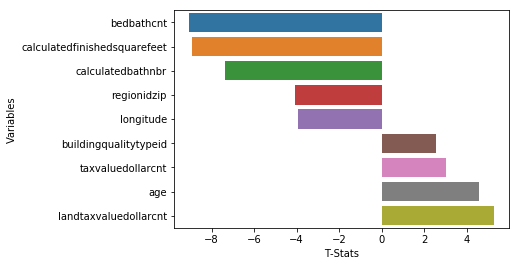

In [10]:
ax = sns.barplot(x="T-Stats", y="Variables", data=Ttest_df)

In [11]:
r, pval = stats.pearsonr(df.age, df.bedbathcnt)

In [12]:
# tbl = pd.crosstab(df['age'], df['regionidzip'])

# stat, p, dof, expected = stats.chi2_contingency(tbl)

In [13]:
# plt.figure(figsize=(16,16))
# sns.heatmap(df.corr(), cmap='icefire', annot=True)

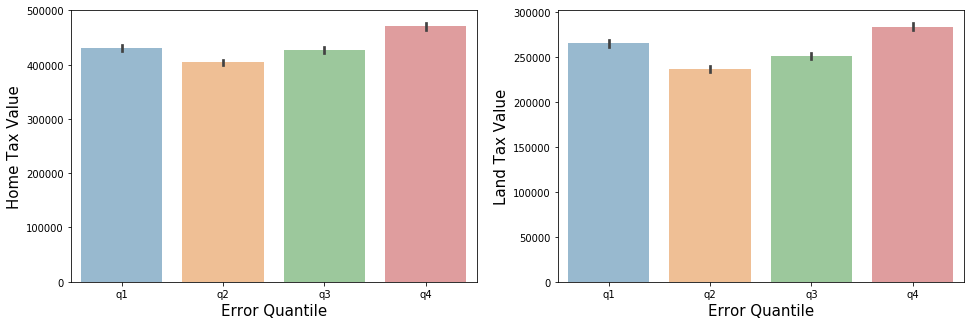

In [14]:
features =  ['taxvaluedollarcnt','landtaxvaluedollarcnt']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

log_rate = df.logerror.mean()

for i, feature in enumerate(features):
    feature_name = ['Home Tax Value','Land Tax Value']
    sns.barplot('error_bin', feature, data=df, ax=ax[i], alpha=.5)
    ax[i].set_xlabel('Error Quantile', fontsize=15)
    ax[i].set_ylabel(feature_name[i], fontsize=15)

In [15]:
Features2cluster = ['latitude','longitude','logerror','bedbathcnt','age']
#  try 1-10 clusters
inertias = []
for thiscluster in range(1, 11):
    df, cluster_inertia, cluster_labels = create_clusters(df,Features2cluster,thiscluster,'cluster_target')
    inertias.append(cluster_inertia)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), inertias)), columns=['n_clusters', 'ssd'])

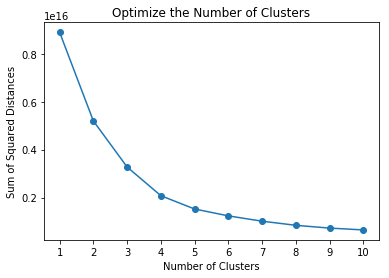

In [16]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Optimize the Number of Clusters')
plt.show()

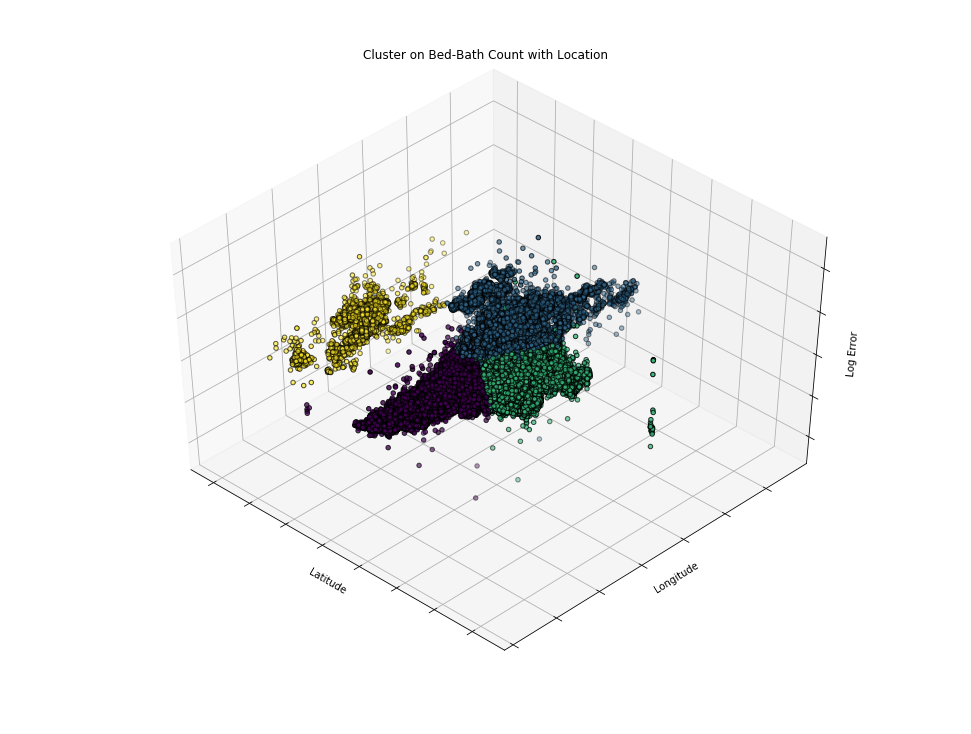

In [17]:

Features2cluster = ['latitude','longitude','logerror','bedbathcnt','age']
fig = plt.figure(1, figsize=(14, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
df, cluster_inertia, cluster_labels = create_clusters(df,Features2cluster,4,'cluster_target')
# plot the points
ax.scatter(df.latitude, df.longitude, df.logerror,
               c=cluster_labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Log Error')

ax.set_title('Cluster on Bed-Bath Count with Location')
ax.dist = 12



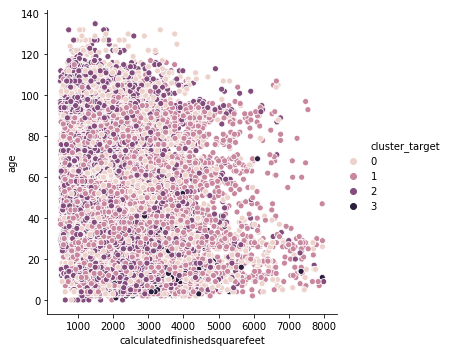

In [32]:
# sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='age', hue='cluster_target')

In [23]:
yfeature = 'logerror'
xfeatures = ['bedbathcnt','calculatedfinishedsquarefeet','age']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.8)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['bedbathcnt', 'calculatedfinishedsquarefeet', 'age']    mse= 0.02373295427106602    rscore= 0.0021804122037396567


In [24]:
xfeatures = ['bedbathcnt','cluster_target','age']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.8)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['bedbathcnt', 'cluster_target', 'age']    mse= 0.023730379729267267    rscore= 0.0022886552908436553


In [25]:
xfeatures = ['cluster_target','age']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.8)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['cluster_target', 'age']    mse= 0.023835998807959138    rscore= -0.002151954350924745


In [26]:
xfeatures = ['cluster_target']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.8)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['cluster_target']    mse= 0.02386943570127442    rscore= -0.0035577627776368637


In [29]:
xfeatures = ['bedbathcnt','calculatedfinishedsquarefeet','age']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.7)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['bedbathcnt', 'calculatedfinishedsquarefeet', 'age']    mse= 0.02373295427106602    rscore= 0.0021804122037396567


In [31]:
xfeatures = ['bedbathcnt','calculatedfinishedsquarefeet','age']
mse, r2, corrdict = regressiontest(df,xfeatures,yfeature,.85)
print(xfeatures,'   mse=',mse,'   rscore=',r2)

['bedbathcnt', 'calculatedfinishedsquarefeet', 'age']    mse= 0.02373295427106602    rscore= 0.0021804122037396567
